In [18]:
import mido
from utils import mido_setup, get_track_instrument_type
import os
import pandas
from collections import Counter

In [21]:
port = mido_setup()

filtered_path = "/Users/edlgg/repos/dissertation/midis/filtered_midis/"
guitar_bass_path = "/Users/edlgg/repos/dissertation/midis/guitar_bass_midis/"
song = mido.MidiFile(guitar_bass_path + "971113.mid")

In [ ]:
def song_has_instruments(song, instruments):
    has_instruments = [False] * len(instruments)
    for i, instrument in enumerate(instruments):
        for track in song.tracks:
            type_ = get_track_instrument_type(track)
            if type_ == instrument:
                has_instruments[i] = True

    for instrument in has_instruments:
        if not instrument:
            return False
    return True

def test_song_has_instruments():
    song = mido.MidiFile(filtered_path + "971113.mid")
    instruments = ["Guitar", "Bass"]
    return song_has_instruments(song, instruments)
# test_song_has_instruments()


In [ ]:
def delete_songs_without_instruments(path, instruments):
    for _, _, filenames in os.walk(path):
        for filename in filenames:
            try:
                song = mido.MidiFile(path + filename)
                print("Loading song: " + filename)
                if song_has_instruments(song, instruments):
                    os.rename(path + filename, guitar_bass_path + filename)
                    print("Moved song: " + filename)

                else:
                    print("Deleted song: " + filename)
                    os.remove(path + filename)
            except:
                print("Error loading: " + filename + " will delete")
                os.remove(path + filename)
# delete_songs_without_instruments(filtered_path, ["Guitar", "Bass"])

In [ ]:
def remove_unused_instruments(initial_path, end_path):
    for _, _, filenames in os.walk(initial_path):
        for filename in filenames:
            try:
                song = mido.MidiFile(initial_path + filename)
                print("Loading song: " + filename)
                mid = mido.MidiFile()
                guitar_track = []
                bass_track = []
                for track in song.tracks:
                    type_ = get_track_instrument_type(track)
                    if type_ == "Guitar" and len(track) > len(guitar_track):
                        guitar_track = track
                    if type_ == "Bass" and len(track) > len(bass_track):
                        bass_track = track
                mid.tracks.append(guitar_track)
                mid.tracks.append(bass_track)
                mid.save(end_path + filename)
                os.remove(initial_path + filename)
            except:
                print("Error with song: " + filename)
                os.remove(initial_path + filename)
remove_unused_instruments(filtered_path, guitar_bass_path)

In [ ]:
def make_sure_everything_is_okey(path):
    for _, _, filenames in os.walk(path):
        for filename in filenames:
            try:
                mid = mido.MidiFile(path + filename)
                print("Loaded: " + filename)
                if len(mid.tracks) != 2:
                    print("Deleted: " + filename)
                    os.remove((path + filename))
            except:
                print("Error with song: " + filename)
                os.remove((path + filename))
# make_sure_everything_is_okey(guitar_bass_path)

In [ ]:
def check_songs_velocities(path):
    has_120_vels = 0
    doesnt = 0
    i = 0
    for _, _, filenames in os.walk(path):
        for filename in filenames:
            has_120 = True
            if i % 100 == 0:
                print(has_120_vels, doesnt)
            i = i + 1
            try:
                mid = mido.MidiFile(path + filename)
                for track in mid.tracks:
                    for msg in track:
                        if msg.type == "note_on":
                            if msg.velocity != 120:
                                has_120 = False
                if has_120:
                    has_120_vels = has_120_vels + 1
                else:
                    doesnt = doesnt + 1
            except:
                print("Error with song: " + filename)
                os.remove((path + filename))
                
    return has_120_vels, doesnt
has_120_vels, doesnt = check_songs_velocities(guitar_bass_path) #124 25376

In [ ]:
def get_lengths_and_notes(path):
    min_notes = []
    max_notes = []
    lens = []
    i = 0
    for _, _, filenames in os.walk(path):
        for filename in filenames:
            if i % 1000 == 0:
                print(i, 25376)
            i = i + 1
            try:
                mid = mido.MidiFile(path + filename)
                for track in mid.tracks:
                    min_note = 999
                    max_note = -1
                    for msg in track:
                        if msg.type == "note_on":
                            if msg.note < min_note:
                                min_note = msg.note
                            if msg.note > max_note:
                                max_note = msg.note
                    min_notes.append(min_note)
                    max_notes.append(max_note)
                    lens.append(len(track))
            except:
                print("Error with song: " + filename)
                os.remove((path + filename))
    return min_notes, max_notes, lens
# min_notes, max_notes, lens = get_lengths_and_notes(guitar_bass_path)
# print(min_notes, max_notes, lens)

In [ ]:
lens.sort()
rounded_lens = list(map(lambda x: round(x, -2), lens))
count = Counter(rounded_lens)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Lens', figsize=(40,5))
# max len 5000

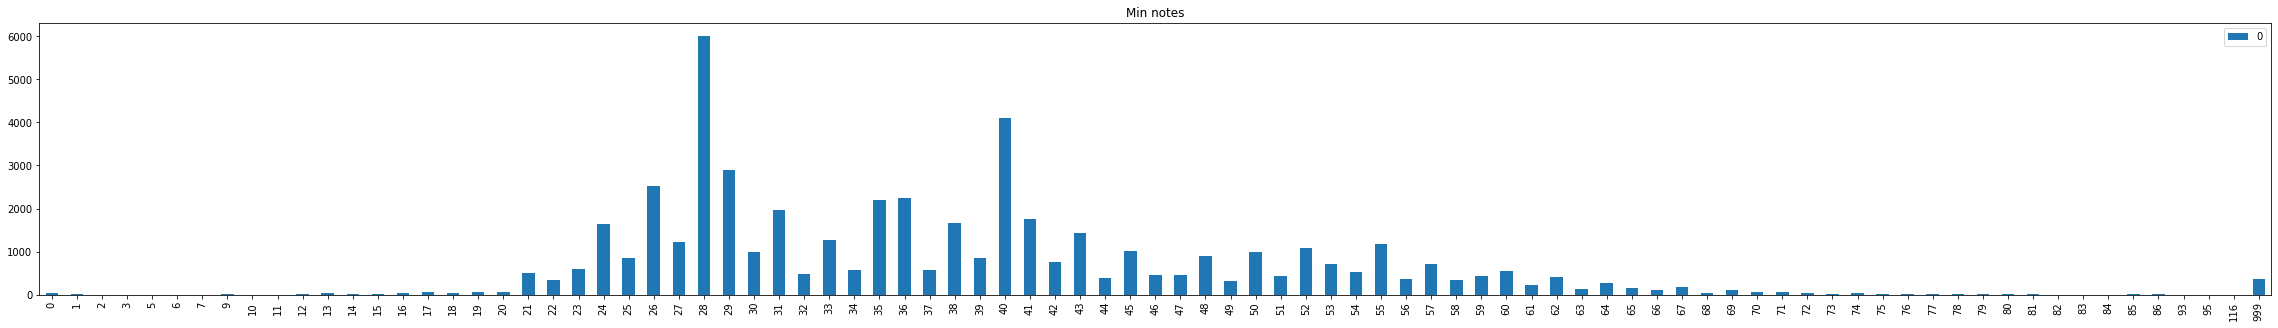

In [35]:
min_notes.sort()
rounded = list(map(lambda x: round(x, -1), min_notes))
count = Counter(min_notes)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Min notes', figsize=(40,5))

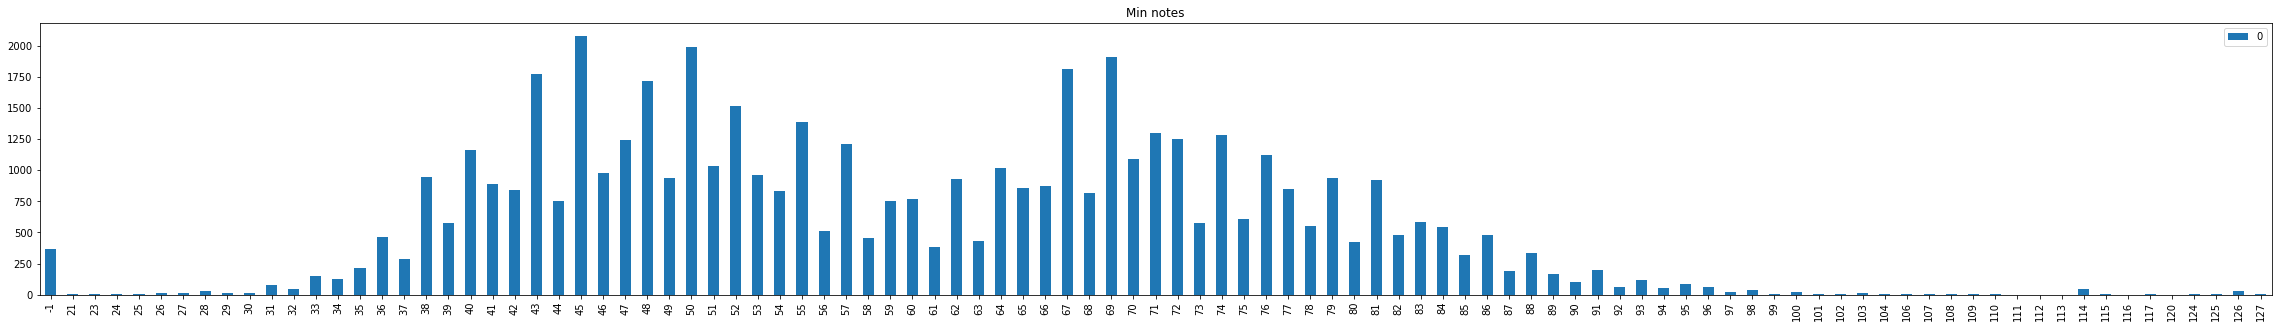

In [36]:
max_notes.sort()
rounded = list(map(lambda x: round(x, -1), max_notes))
count = Counter(max_notes)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar', title='Min notes', figsize=(40,5))

In [11]:
def multifilter(initial_path, final_path):
    i = 0
    for _, _, filenames in os.walk(initial_path):
        for filename in filenames:
            if i % 1000 == 0:
                print(i, 25376)
            i = i + 1
            try:
                mid = mido.MidiFile(initial_path + filename)
                min_note = 999
                max_note = -1
                for track in mid.tracks:
                    for msg in track:
                        if msg.type == "note_on":
                            if msg.note < min_note:
                                min_note = msg.note
                            if msg.note > max_note:
                                max_note = msg.note
                if min_note > 20 and min_note != 999 and max_note < 90 and max_note != -1 and len(mid.tracks[0]) < 4000 and len(mid.tracks[1]) < 4000:
                    os.rename(initial_path + filename, final_path + filename)
                else:
                    os.remove(initial_path + filename)
            except Exception as e:
                print("Error with song: " + filename)
                print(e)
                os.remove(initial_path + filename)
                
initial_path = "/Users/edlgg/repos/dissertation/midis/guitar_bass_midis/"
final_path = "/Users/edlgg/repos/dissertation/midis/guitar_bass_filtered/"
multifilter(initial_path, final_path)

0 25376
1000 25376
2000 25376
3000 25376
4000 25376
5000 25376


In [16]:
#get_track_ins
def clean_songs(initial_path, final_path):
    i = 0
    for _, _, filenames in os.walk(initial_path):
        for filename in filenames:
            try:
                if i % 100 == 0:
                    print(i)
                i = i + 1
                old_mid = mido.MidiFile(initial_path + filename)

                track_one_type = get_track_instrument_type(old_mid.tracks[0])
                guitar = None
                bass = None
                if track_one_type == "Guitar":
                    guitar = old_mid.tracks[0]
                    bass = old_mid.tracks[1]
                else:
                    guitar = old_mid.tracks[1]
                    bass = old_mid.tracks[0]

                new_guitar = mido.MidiTrack()
                new_guitar.append(mido.Message('program_change', program=28, time=0))
                for msg in guitar:
                    if msg.type == "note_on":
                        new_guitar.append(msg)

                new_bass = mido.MidiTrack()
                new_bass.append(mido.Message('program_change', program=35, time=0))
                for msg in bass:
                    if msg.type == "note_on":
                        new_bass.append(msg)


                new_mid = mido.MidiFile()
                new_mid.tracks.append(new_guitar)
                new_mid.tracks.append(new_bass)
                new_mid.save(final_path + filename)
                os.remove(initial_path + filename)
            except Exception as e:
                print(filename, e)
            
initial_path = "/Users/edlgg/repos/dissertation/midis/guitar_bass_filtered/"
final_path = "/Users/edlgg/repos/dissertation/midis/clean_songs/"
clean_songs(initial_path, final_path)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
.DS_Store MThd not found. Probably not a MIDI file
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600

In [23]:
def get_instrument_track(mid, desired_type):
    desired_track = mido.MidiTrack()
    for track in mid.tracks:
        track_type = get_track_instrument_type(track)
        if track_type == desired_type and len(track) > len(desired_track):
            desired_track = track
    return desired_track

In [41]:
def validate_notes_and_vels(mid):
    min_ = 999
    max_ = -1
    has_0_vel = False
    has_note_off = False
    has_control_change = False
    for track in mid.tracks:
        for msg in track:
            if msg.type == "note_on":
                if msg.note < min_:
                    min_ = msg.note
                if msg.note > max_:
                    max_ = msg.note
                if msg.velocity == 0:
                    has_0_vel = True
            if msg.type == "note_off":
                has_note_off = True
            if msg.type == "control_change":
                has_control_change = True
    if min_ == 999 or min_ < 20 or max_ == -1 or max_ > 90 or (has_0_vel and has_note_off) or (not has_0_vel and not has_note_off):
        return False, has_control_change, has_0_vel, has_note_off
    return True, has_control_change, has_0_vel, has_note_off

In [47]:
def master_filter():
    initial_path = "/Users/edlgg/repos/dissertation/midis/all_midis/"
    final_path = "/Users/edlgg/repos/dissertation/midis/v3/" 
    allowed_ticks = [120, 384, 480, 192]
    i = 0
    for _, _, filenames in os.walk(initial_path):
        for filename in filenames:
            try:
                if i % 1000 == 0:
                    print(i, str(117102))
                i = i + 1
                old_mid = mido.MidiFile(initial_path + filename)
                ticks_per_beat = old_mid.ticks_per_beat
                is_valid, has_control_change, has_0_vel, has_note_off = validate_notes_and_vels(old_mid)
                if ticks_per_beat in allowed_ticks and is_valid:
                    guitar = get_instrument_track(old_mid, "Guitar")
                    bass = get_instrument_track(old_mid, "Bass")
                    
                    if len(guitar) > 500 and len(bass) > 500:
                        new_guitar = mido.MidiTrack()
                        new_guitar.append(mido.Message('program_change', program=26, time=0))
                        for msg in guitar:
                            if msg.type == "note_on":
                                new_guitar.append(msg)

                        new_bass = mido.MidiTrack()
                        new_bass.append(mido.Message('program_change', program=34, time=0))
                        for msg in bass:
                            if msg.type == "note_on":
                                new_bass.append(msg)

                        new_mid = mido.MidiFile()
                        new_mid.ticks_per_beat = ticks_per_beat
                        new_mid.tracks.append(new_guitar)
                        new_mid.tracks.append(new_bass)
                        
                        path = final_path
                        if has_control_change:
                            path = path + "control_change/" 
                        else:
                            path = path +  "no_control_change/"
                        if has_0_vel:
                            path = path + "0_vel/"
                        else:
                            path = path + "note_off/"
                        path = path + str(ticks_per_beat) + "/" + filename
                        new_mid.save(path)
                    os.remove(initial_path + filename)
            except Exception as e:
                print("Error with file: ", filename)
                print(" Error: " , e)
                os.remove(initial_path + filename)
master_filter()              
                

0 117102
Error with file:  warcraft.mid
 Error:  
Error with file:  Spear K - Astromon.mid
 Error:  MThd not found. Probably not a MIDI file
Error with file:  B5th_3g.mid
 Error:  Could not decode key with 10 sharps and mode 0
Error with file:  victory-4.mid
 Error:  Could not decode key with 3 flats and mode 255
Error with file:  inlambs.mid
 Error:  Could not decode key with 3 flats and mode 21
Error with file:  IWill2.mid
 Error:  MThd not found. Probably not a MIDI file
Error with file:  LWmid.mid
 Error:  
Error with file:  kainoe.mid
 Error:  data byte must be in range 0..127
Error with file:  Misja Helsloot - First Second (Ralphie B Remix).mid
 Error:  list index out of range
Error with file:  Lady Gaga - Hair.mid
 Error:  data byte must be in range 0..127
Error with file:  because_u_love_me.mid
 Error:  MThd not found. Probably not a MIDI file
Error with file:  Prelude op32 n5 .mid
 Error:  MThd not found. Probably not a MIDI file
Error with file:  SailorScoutsTransformationAnd